# Animate parameter fitting

In [1]:
import numpy as np
import helper_module as hm
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import trapz
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)

In [2]:
def delta(y, Pe):
    return np.sqrt(4 * y / Pe)


def physisorption(x, y, Pe):
    return 1.0 - erf(x / delta(y, Pe))


def decay(x, y, Pe, Da):
    return 0.5 * (
        np.exp( np.sqrt(Pe * Da) * x) * (1 - erf(x / delta(y, Pe) + np.sqrt(Da * y))) +
        np.exp(-np.sqrt(Pe * Da) * x) * (1 - erf(x / delta(y, Pe) - np.sqrt(Da * y)))
    )

## Plot boundary layer solutions

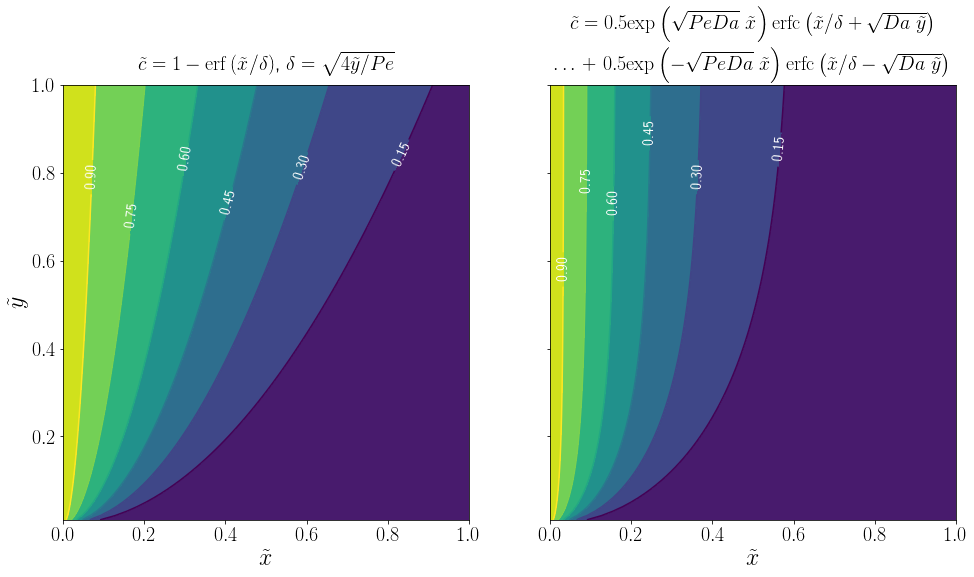

In [3]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(hm.figure_width, 8), sharey=True)

x = np.linspace(0, 1, 100)
y = np.linspace(1.0E-2, 1, 100)

X, Y = np.meshgrid(x, y)

ax1.contourf(X, Y, physisorption(X, Y, 5.0))
cont_1 = ax1.contour(X, Y, physisorption(X, Y, 5.0))
ax1.clabel(cont_1, inline=True, fontsize=hm.fontsize_contour, colors="w", fmt='%1.2f')
ax2.contourf(X, Y, decay(X, Y, 5.0, 2.0))
cont_2 = ax2.contour(X, Y, decay(X, Y, 5.0, 2.0))
ax2.clabel(cont_2, inline=True, fontsize=hm.fontsize_contour, colors="w", fmt='%1.2f')

dec_I = r"$\tilde{c}=$" 
dec_II = r"$0.5 \mathrm{exp}\left(\sqrt{Pe Da}\ \tilde{x}\right) \mathrm{erfc}\left( \tilde{x}/\delta + \sqrt{Da\ \tilde{y}} \right)$"
dec_III = r"$ +\ 0.5 \mathrm{exp}\left(-{\sqrt{Pe Da}\ \tilde{x}}\right) \mathrm{erfc}\left( \tilde{x}/\delta - \sqrt{Da\ \tilde{y}} \right)$"
titles = [
    r"$\tilde{c}=1 - \mathrm{erf}\left(\tilde{x}/\delta\right)$, $\delta = \sqrt{4\tilde{y}/Pe}$",
    "{}\ {}\n {}\ {}".format(dec_I, dec_II, r"$\dots$", dec_III)
]

for title, ax in zip(titles, [ax1, ax2]):
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
    ti = ax.set_title(title, fontsize=20)
    ti.set_position([0.5, 1.02])

ax1.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
plt.savefig("../output/simple_substitude_problem.png", bbox_inches="tight")

## Animate distance-based fitting

Create video by running

```
ffmpeg -framerate 10 -i simple_substitude_problem_%03d.png -c:v libx264 -vf scale=1320:-2 -pix_fmt yuv420p distance_fitting.mp4
```

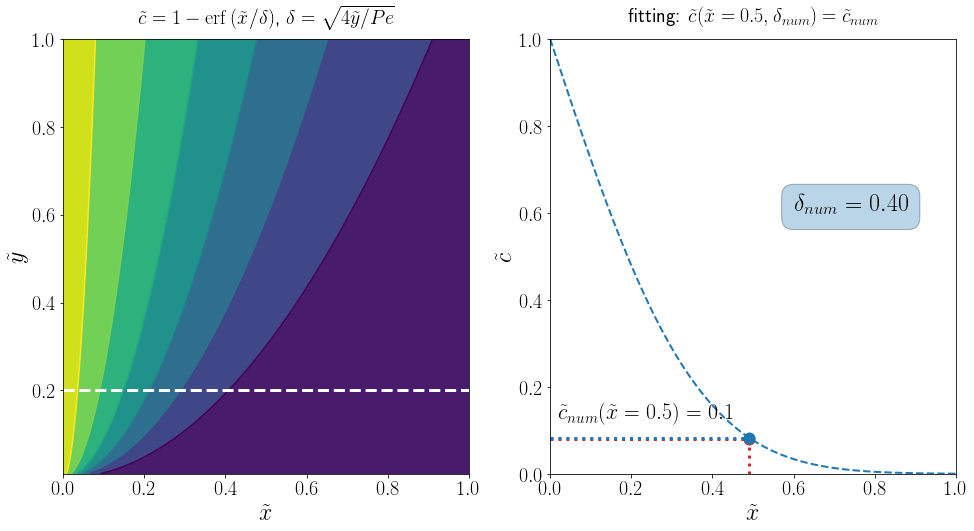

In [12]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(hm.figure_width, 8))

points = 100
x = np.arange(0, 1+1.0E-6, 1.0/points)
y = np.linspace(1.0E-2, 1, points)

X, Y = np.meshgrid(x, y)

sol = physisorption(X, Y, 5.0)
pos_init = int(0.5*points)
bbox = dict(facecolor='C0', alpha=0.3, boxstyle='round,pad=0.5')

ax1.contourf(X, Y, sol)
cont_1 = ax1.contour(X, Y, physisorption(X, Y, 5.0))
ax1.axhline(y[pos_init], ls="--", color="w", lw=3)

profile, = ax2.plot(x, sol[pos_init], ls="--", lw=2, color="C0")
ax2.scatter([x[49]], [sol[pos_init, 79]], color="C3", marker="o", s=120)
ax2.text(0.02, 0.12, r"$\tilde{c}_{num}(\tilde{x}=0.5) = 0.1$", fontsize=22)
ax2.axhline(sol[pos_init, 79], 0.0, x[49], ls=":", lw=3, color="C3")
ax2.axvline(x[49], 0.0, sol[pos_init, 79], ls=":", lw=3, color="C3")
dot_sol = ax2.scatter([x[pos_init]], [sol[pos_init, 49]], color="C0", marker="o", s=120, zorder=6)
ax2.axhline(sol[pos_init, 49], 0.0, 0.5, ls=":", lw=3, color="C0")
delta_text = ax2.text(0.6, 0.6, r"$\delta_{:s} = {:1.2f}$".format("{num}", delta(y[pos_init], 5.0)), fontsize=hm.fontsize_label, bbox=bbox)

ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel(r"$\tilde{c}$", fontsize=hm.fontsize_label)

for ax in  [ax1, ax2]:
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)

ax1.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
ti_1 = ax1.set_title(r"$\tilde{c}=1 - \mathrm{erf}\left(\tilde{x}/\delta\right)$, $\delta = \sqrt{4\tilde{y}/Pe}$", fontsize=20)
ti_1.set_position([0.5, 1.02])
ti_2 = ax2.set_title(r"fitting: $\tilde{c}(\tilde{x}=0.5, \delta_{num}) = \tilde{c}_{num}$", fontsize=20)
ti_2.set_position([0.5, 1.02])

path = "../output/distance_fitting/"
!mkdir -p {path}

for frame in range(points - 1, 0, -1):
    if sol[frame, 49] >= sol[pos_init, 79]:
        profile.set_data(x, sol[frame])
        del ax1.lines[-1]
        ax1.axhline(y[frame], ls="--", color="w", lw=3)
        del ax2.lines[-1]
        ax2.axhline(sol[frame, 49], 0.0, 0.5, ls=":", lw=3, color="C0")
        dot_sol._offsets = np.c_[[x[49]], [sol[frame, 49]]]
        hline_ind = len(ax1.lines) - 1
        delta_text.set_text(r"$\delta_{:s} = {:1.2f}$".format("{num}", delta(y[frame], 5.0)))
    plt.savefig(path + "simple_substitude_problem_{:03d}.png".format(points - frame - 1), bbox_inches="tight")

## Integral fitting

Create video by running

```
ffmpeg -framerate 10 -i simple_substitude_problem_%03d.png -c:v libx264 -vf scale=1320:-2 -pix_fmt yuv420p integral_fitting.mp4
```

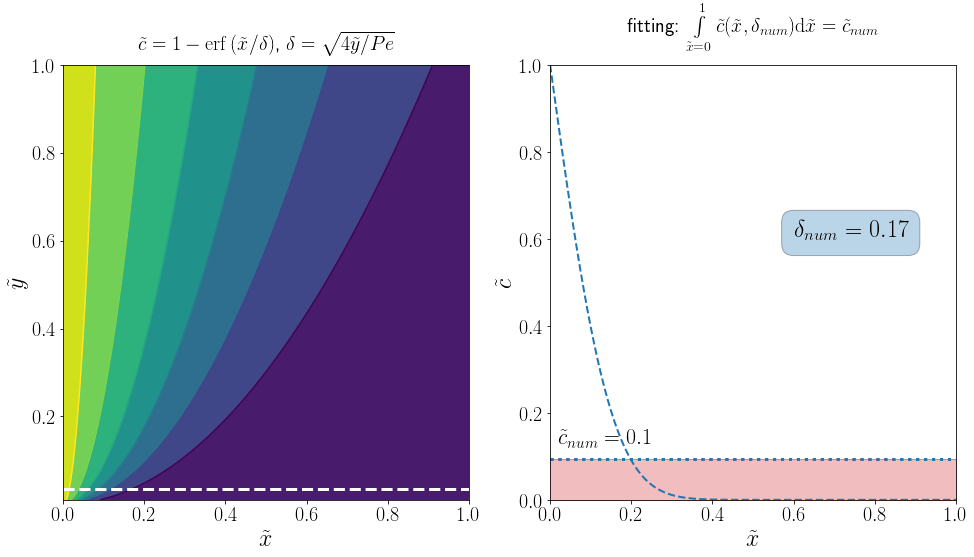

In [14]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(hm.figure_width, 8))

points = 120
x = np.arange(0, 1+1.0E-6, 1.0/points)
y = np.linspace(1.0E-2, 1, points)

X, Y = np.meshgrid(x, y)

sol = physisorption(X, Y, 5.0)
pos_init = int(0.5*points)
bbox = dict(facecolor='C0', alpha=0.3, boxstyle='round,pad=0.5')

ax1.contourf(X, Y, sol)
cont_1 = ax1.contour(X, Y, physisorption(X, Y, 5.0))
ax1.axhline(y[pos_init], ls="--", color="w", lw=3)

profile, = ax2.plot(x, sol[pos_init], ls="--", lw=2, color="C0")
av_ref = trapz(sol[3], x)
ax2.text(0.02, 0.12, r"$\tilde{c}_{num} = 0.1$", fontsize=22)
ax2.fill_between([0.0, 1.0], [av_ref, av_ref], color="C3", alpha=0.3)
ax2.axhline(av_ref, 0.0, 1.0, ls=":", lw=3, color="C3")

prof_av = trapz(sol[pos_init], x)
fill = ax2.fill_between([0.0, 1.0], [prof_av, prof_av], [av_ref, av_ref], color="C0", alpha=0.3)
ax2.axhline(prof_av, 0.0, 1.0, ls=":", lw=3, color="C0")
delta_text = ax2.text(0.6, 0.6, r"$\delta_{:s} = {:1.2f}$".format("{num}", delta(y[pos_init], 5.0)), fontsize=hm.fontsize_label, bbox=bbox)

ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel(r"$\tilde{c}$", fontsize=hm.fontsize_label)

for ax in  [ax1, ax2]:
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)

ax1.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
ti_1 = ax1.set_title(r"$\tilde{c}=1 - \mathrm{erf}\left(\tilde{x}/\delta\right)$, $\delta = \sqrt{4\tilde{y}/Pe}$", fontsize=20)
ti_1.set_position([0.5, 1.02])
ti_2 = ax2.set_title(r"fitting: $\int\limits_{\tilde{x}=0}^{1}\tilde{c}(\tilde{x}, \delta_{num})\mathrm{d}\tilde{x} = \tilde{c}_{num}$", fontsize=20)
ti_2.set_position([0.5, 1.02])

path = "../output/integral_fitting/"
!mkdir -p {path}

for frame in range(points - 1, 0, -1):
    prof_av = trapz(sol[frame], x)
    if prof_av >= av_ref:
        profile.set_data(x, sol[frame])
        del ax1.lines[-1]
        ax1.axhline(y[frame], ls="--", color="w", lw=3)
        del ax2.lines[-1]
        prof_av = trapz(sol[frame], x)
        ax2.axhline(prof_av, 0.0, 1.0, ls=":", lw=3, color="C0")
        dot_sol._offsets = np.c_[[x[49]], [sol[frame, 49]]]
        fill.remove()
        fill = ax2.fill_between([0.0, 1.0], [prof_av, prof_av], [av_ref, av_ref], color="C0", alpha=0.3)
        delta_text.set_text(r"$\delta_{:s} = {:1.2f}$".format("{num}", delta(y[frame], 5.0)))
    plt.savefig(path + "simple_substitude_problem_{:03d}.png".format(points - frame - 1), bbox_inches="tight")